## Problem

Using the smartphone's accelerometer inside an elevator, we want to estimate the speed and the height travelled.

In [1]:
# Load libraries

%pylab inline
import pandas as pd
from scipy import integrate
import numpy as np

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Read the data

The data has been generated with the app _Science Journal_, available for _Android_. It registers, among others, the accelerations of the device.

In [2]:
# Import the time series corresponding to acceleration in the vertical axis
data = pd.read_csv('./data/skyscrapper_up.csv', usecols=['relative_time', 'AccZ'])

# Drop the not-a-number cases
data = data.dropna()

# Extract the relevant information in a matrix form
ts = data.relative_time/1000 # Time (in s)
az = data.AccZ # Vertical acceleration (in m/s^2)

## Clean the time series

The time span of the recorded time series is a bit longer than desired. It registered the movement of the experimenter hand while setting the phone on the floor of the elevator, as well as the recovery of it. We want to cut off these chunks of the time series.

In [3]:
# indices[0] = start of experiment
# indices[1] = phone on the floor
# indices[2] = end of phone on the floor
# indices[3] = end of experiment
indices = [0, 200, 1700, ts.size]

# Time series while setting the phone on the floor
ts_init = ts[indices[0]:indices[1]]
az_init = az[indices[0]:indices[1]]

# The really interesting time series: while the phone is on the floor and the only registered movement is the elevator's
ts_experiment = ts[indices[1]:indices[2]]
az_experiment = az[indices[1]:indices[2]]

# Time series while taking the phone from the floor
ts_out = ts[indices[2]:indices[3]]
az_out = az[indices[2]:indices[3]]

## Plot time series

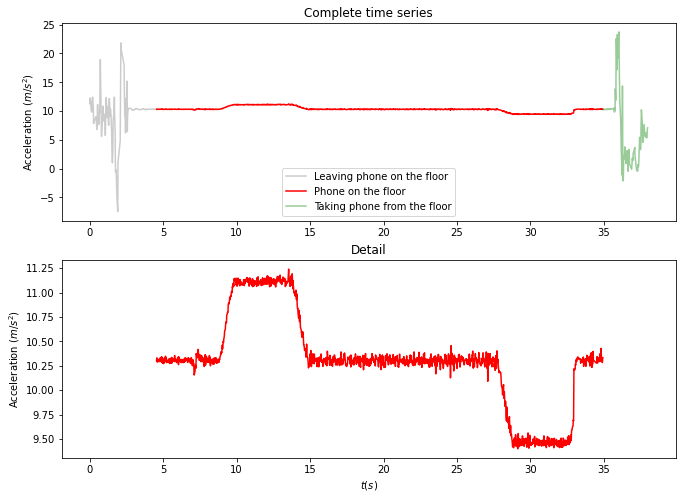

In [4]:
plt.rcParams['figure.figsize'] = (11, 8)
plt.rcParams['font.size'] = 10.0

fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)

plt.title('Complete time series')
plt.plot(ts_init, az_init, color='gray', alpha=0.4)
plt.plot(ts_experiment, az_experiment, color='red')
plt.plot(ts_out, az_out, color='green', alpha=0.4)

plt.ylabel('Acceleration $(m / s^2)$')
plt.legend(['Leaving phone on the floor', 'Phone on the floor', 'Taking phone from the floor']);

ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
plt.title('Detail')
plt.plot(ts_experiment, az_experiment, color='red')

plt.xlabel('$t (s)$')
plt.ylabel('Acceleration $(m / s^2)$')

## Plot acceleration only

This is useful for generating figures.

Text(0, 0.5, 'Acceleration $(m / s^2)$')

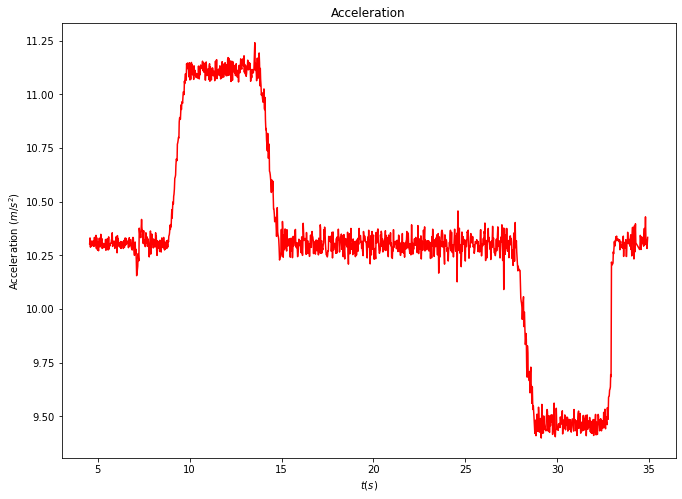

In [10]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)

plt.title('Acceleration')
plt.plot(ts_experiment, az_experiment, color='red')

plt.xlabel('$t (s)$')
plt.ylabel('Acceleration $(m / s^2)$')

## Estimate g

The phone registers simultaneously two accelerations:

* That due to the elevator's movement ($a$).
* That due to the Earth's gravitational field ($g$).

Despite we know that, in the Earth's surface, $g \approx 9.8 m/s^2$, we don't know anything about possible systematic errors of our device. Indeed, a quick look at our previous figure shows that the registered $g$ is slightly higher than $10 m/s^2$. In order to assess this problem, we'll estimate the measured value of $g$ as the mean value of our main time series.

This gravitational acceleration is not relevant to the problem we want to solve, so we'll remove its effect by substracting its estimated value.

In [5]:
g = az_experiment.mean()
az_experiment_detrended = az_experiment - g 

## Integrate

The relationship between position ($x$), speed ($v$) and acceleration ($a$) is well known:

$$v(t) = x'(t)$$

and:

$$a(t) = v'(t)$$

Using anti derivatives we can go the other way around:

$$v(t) = \int_{t_0}^t a(s) ds$$

and:

$$x(t) = \int_{t_0}^t v(s) ds$$

In [6]:
# Approximate antiderivative of a
v = np.zeros(ts_experiment.size-1)
for i in range(1, ts_experiment.size):
    y_temp = az_experiment_detrended[:i]
    t_temp = ts_experiment[:i]
    v[i-1] = integrate.simps(y_temp, t_temp, even='avg')
    
# Approximate antiderivative of v
x = np.zeros(ts_experiment.size-2)
for i in range(1, ts_experiment.size-1):
    y_temp = v[:i]
    t_temp = ts_experiment[:i]
    x[i-1] = integrate.simps(y_temp, t_temp, even='avg')

## Plot the conclusions

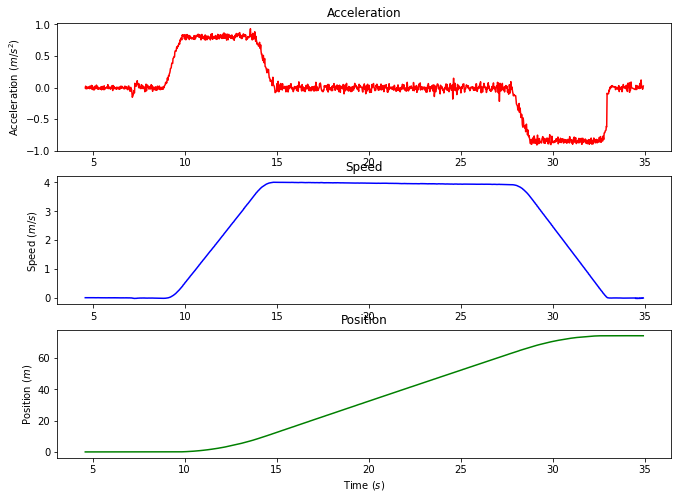

In [7]:
plt.subplot(311)
plt.title('Acceleration')
plt.plot(ts_experiment, az_experiment_detrended, color='red')
plt.ylabel('Acceleration $(m / s^2)$')

plt.subplot(312)
plt.title('Speed')
plot(ts_experiment[1:], v, color='blue')
plt.ylabel('Speed $(m / s)$')

plt.subplot(313)
plt.title('Position')
plot(ts_experiment[2:], x, color='green')
plt.ylabel('Position $(m)$')

plt.xlabel('Time $(s)$');

In [8]:
print('The estimated g is {0:.2f} (m/s^2).'.format(g))
print('The travelled height is {0:.2f} (m).'.format(x.max()))
print('The maximum speed is {0:.2f} (m/s).'.format(v.max()))
print('The maximum acceleration is {0:.2f} (m/s^2).'.format(az_experiment_detrended.max()))

The estimated g is 10.31 (m/s^2).
The travelled height is 74.30 (m).
The maximum speed is 4.01 (m/s).
The maximum acceleration is 0.93 (m/s^2).
